Load data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)
random.seed(134)
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

0.4.1


In [3]:
train_data = pd.read_csv('./hw2_data/snli_train.tsv', sep='\t')
val_data = pd.read_csv('./hw2_data/snli_val.tsv', sep='\t') 

In [4]:
train_data.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [5]:
train_data.label.unique()

array(['neutral', 'entailment', 'contradiction'], dtype=object)

In [6]:
def label(sent):
    if sent == 'contradiction':
        return 0;
    elif sent == 'neutral':
        return 1;
    elif sent == 'entailment':
        return 2;

In [7]:
train_data['label'] = train_data['label'].apply(label)
val_data['label'] = val_data['label'].apply(label)

In [8]:
print(train_data.label.unique())
print(val_data.label.unique())

[1 2 0]
[0 2 1]


In [9]:
def tokenize(sent):
    string = sent.lower();
    return string.split();

In [10]:
train_data['sentence1'] = train_data['sentence1'].apply(tokenize)
train_data['sentence2'] = train_data['sentence2'].apply(tokenize)
val_data['sentence1'] = val_data['sentence1'].apply(tokenize)
val_data['sentence2'] = val_data['sentence2'].apply(tokenize)

In [11]:
train_data.head()

,sentence1,sentence2,label
0,"[a, young, girl, in, a, pink, shirt, sitting, ...","[a, young, girl, watching, the, sunset, over, ...",1
1,"[a, woman, is, smiling, while, the, man, next,...","[two, people, are, next, to, each, other, .]",2
2,"[across, the, river, ,, you, can, see, a, larg...","[the, large, building, is, full, of, apartment...",1
3,"[a, man, in, white, shorts, and, a, black, shi...","[a, man, is, riding, a, jetski, on, the, ocean...",0
4,"[four, black, dogs, run, together, on, bright,...","[four, dogs, are, preparing, to, be, launched,...",0


In [12]:
all_chars = []

MAX_WORD_LENGTH_S1 = 0
for sentence in train_data['sentence1']:
    for word in sentence:
        all_chars.append(word);
    MAX_WORD_LENGTH_S1 = max(MAX_WORD_LENGTH_S1, len(sentence))
        
MAX_WORD_LENGTH_S2 = 0
for sentence in train_data['sentence2']:
    for word in sentence:
        all_chars.append(word);
    MAX_WORD_LENGTH_S2 = max(MAX_WORD_LENGTH_S2, len(sentence))

In [13]:
print(MAX_WORD_LENGTH_S1)
print(MAX_WORD_LENGTH_S2)

82
41


In [14]:
unique_chars = list(set(all_chars))
char2id = dict(zip(unique_chars, range(2,2+len(unique_chars))))
id2char = ['<pad>', '<unk>'] + unique_chars
char2id['<pad>'] = PAD_IDX
char2id['<unk>'] = UNK_IDX

In [15]:
print(len(id2char))
print(len(char2id))

21025
21025


Load pre-embeddings

In [16]:
ft_home = './'
words_to_load = 999995 # maximum value in the file

with open(ft_home + '/wiki-news-300d-1M.vec', encoding='utf-8') as f:
    loaded_embeddings_ft = np.zeros((words_to_load, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i, :] = np.asarray(s[1:])
        words_ft[s[0]] = i
        idx2words_ft[i] = s[0]
        ordered_words_ft.append(s[0])

In [17]:
print(loaded_embeddings_ft.shape)
print(len(idx2words_ft))
print(len(words_ft))
print(len(ordered_words_ft))

(999995, 300)
999995
999995
999995


In [18]:
pre_embedding_matrix = np.zeros([len(id2char), 300])

num = 0
for word in id2char:
    try:
        pre_embedding_matrix[char2id[word]] = loaded_embeddings_ft[words_ft[word]]
    except KeyError:
        pre_embedding_matrix[char2id[word]] = np.zeros(300)
        num = num + 1

In [19]:
print(num/len(id2char) * 100, 'percent of all the tokens do not appear in the pretrained embeddings.')

9.869203329369798 percent of all the tokens do not appear in the pretrained embeddings.


In [20]:
print(pre_embedding_matrix.shape)

(21025, 300)


In [17]:
#pkl.dump(id2char, open("./id2char.p", "wb"))
#pkl.dump(char2id, open("./char2id.p", "wb"))
#pkl.dump(pre_embedding_matrix, open("./pre_embedding_matrix.p", "wb"))

In [16]:
#id2char = pkl.load(open("./id2char.p","rb"))
#char2id = pkl.load(open("./char2id.p","rb"))
#pre_embedding_matrix = pkl.load(open("./pre_embedding_matrix.p","rb"))

Build dataloader

In [17]:
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, char2id):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list1, self.data_list2, self.target_list = zip(*data_tuple)
        assert ((len(self.data_list1) == len(self.target_list)) and (len(self.data_list2) == len(self.target_list)))
        self.char2id = char2id

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        char_idx1 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.data_list1[key][:MAX_WORD_LENGTH_S1]]
        char_idx2 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.data_list2[key][:MAX_WORD_LENGTH_S2]]
        label = self.target_list[key]
        return [char_idx1, char_idx2, len(char_idx1), len(char_idx2), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    length_list = []

    for datum in batch:
        length_list1.append(datum[2])
        length_list2.append(datum[3])
        label_list.append(datum[4])
        length_list.append(max(datum[2], datum[3]))
        
    # padding
    MAX_WORD_LENGTH = max(MAX_WORD_LENGTH_S1, MAX_WORD_LENGTH_S2)
    
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    ind_dec_order = np.argsort(length_list)[::-1]
    data_list1 = np.array(data_list1)[ind_dec_order]
    data_list2 = np.array(data_list2)[ind_dec_order]
    length_list1 = np.array(length_list1)[ind_dec_order]
    length_list2 = np.array(length_list2)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list1), torch.LongTensor(length_list2), torch.LongTensor(label_list)]

In [18]:
train = []
for data in train_data.values:
    train.append(tuple(data))
    
val = []
for data in val_data.values:
    val.append(tuple(data))

In [128]:
# Build train, valid and test dataloaders

train_dataset = VocabDataset(train, char2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val, char2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

Model: CNN

In [129]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, kernel_size, dropout):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(pre_embedding_matrix))
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)

        self.fc1 = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
                         
    def forward(self, x1, x2):
        batch_size, seq_len1 = x1.size()
        _, seq_len2 = x2.size()

        embed1 = self.embedding(x1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        hidden1 = torch.sum(hidden1, dim=1)
        
        embed2 = self.embedding(x2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
        hidden2 = torch.sum(hidden2, dim=1)
        
        logits = self.fc1(torch.cat([hidden1, hidden2], 1))
        logits = self.relu(logits)
        logits = self.dropout(logits)
        logits = self.fc2(logits)
        return logits

In [130]:
cuda = torch.device('cuda')

In [131]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    losses = 0
    model.eval()
    for data1, data2, lengths1, lengths2, labels in loader:
        data1_batch, data2_batch, lengths1_batch, lengths2_batch, label_batch = data1, data2, lengths1, lengths2, labels
        outputs = F.softmax(model(data1_batch.to(device=cuda).long(), data2_batch.to(device=cuda).long()), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        total += labels.size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
        losses += loss.item()
    return (100 * correct / total), losses/len(loader)

In [132]:
model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char), kernel_size=3, dropout=0.1).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_200_3_1 = []
val_accu_200_3_1 = []
train_loss_200_3_1 = []
val_loss_200_3_1 = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long())
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            train_accu_200_3_1.append(train_acc)
            val_accu_200_3_1.append(val_acc)
            train_loss_200_3_1.append(train_los)
            val_loss_200_3_1.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))

Epoch: [1/5], Step: [101/3125], Train Accu: 47.485, Validation Accu: 45.5, Train Loss: 1.0703056801605224, Val Loss: 1.0722765438258648
Epoch: [1/5], Step: [201/3125], Train Accu: 56.247, Validation Accu: 53.9, Train Loss: 1.0156791129302978, Val Loss: 1.0267463810741901
Epoch: [1/5], Step: [301/3125], Train Accu: 59.47, Validation Accu: 58.1, Train Loss: 0.9841291440391541, Val Loss: 0.9927045702934265
Epoch: [1/5], Step: [401/3125], Train Accu: 59.97, Validation Accu: 56.5, Train Loss: 0.9855125584793091, Val Loss: 0.9951020702719688
Epoch: [1/5], Step: [501/3125], Train Accu: 62.304, Validation Accu: 60.4, Train Loss: 0.9530424361038208, Val Loss: 0.9648377597332001
Epoch: [1/5], Step: [601/3125], Train Accu: 62.228, Validation Accu: 61.8, Train Loss: 0.9519224460792541, Val Loss: 0.9645225517451763
Epoch: [1/5], Step: [701/3125], Train Accu: 63.619, Validation Accu: 61.6, Train Loss: 0.9465535010719299, Val Loss: 0.9584212154150009
Epoch: [1/5], Step: [801/3125], Train Accu: 64.486

Epoch: [2/5], Step: [3101/3125], Train Accu: 77.065, Validation Accu: 70.1, Train Loss: 0.828723207912445, Val Loss: 0.8842460997402668
Epoch: [3/5], Step: [101/3125], Train Accu: 77.336, Validation Accu: 69.8, Train Loss: 0.8068237868690491, Val Loss: 0.8688611723482609
Epoch: [3/5], Step: [201/3125], Train Accu: 76.754, Validation Accu: 66.6, Train Loss: 0.8162716878890991, Val Loss: 0.8850834369659424
Epoch: [3/5], Step: [301/3125], Train Accu: 77.678, Validation Accu: 67.9, Train Loss: 0.8177126769256592, Val Loss: 0.8873610571026802
Epoch: [3/5], Step: [401/3125], Train Accu: 78.04, Validation Accu: 68.2, Train Loss: 0.8139941609764099, Val Loss: 0.8813915699720383
Epoch: [3/5], Step: [501/3125], Train Accu: 77.708, Validation Accu: 68.0, Train Loss: 0.8181980375289917, Val Loss: 0.8872586563229561
Epoch: [3/5], Step: [601/3125], Train Accu: 78.017, Validation Accu: 68.7, Train Loss: 0.8126909762763977, Val Loss: 0.8845488969236612
Epoch: [3/5], Step: [701/3125], Train Accu: 77.66

Epoch: [4/5], Step: [3001/3125], Train Accu: 85.037, Validation Accu: 67.9, Train Loss: 0.7533803036880493, Val Loss: 0.8773157242685556
Epoch: [4/5], Step: [3101/3125], Train Accu: 85.4, Validation Accu: 68.3, Train Loss: 0.7619202603912354, Val Loss: 0.8829858265817165
Epoch: [5/5], Step: [101/3125], Train Accu: 85.656, Validation Accu: 68.8, Train Loss: 0.7361017286491394, Val Loss: 0.8689276780933142
Epoch: [5/5], Step: [201/3125], Train Accu: 85.625, Validation Accu: 68.2, Train Loss: 0.7303642252159118, Val Loss: 0.8647741600871086
Epoch: [5/5], Step: [301/3125], Train Accu: 85.434, Validation Accu: 68.3, Train Loss: 0.7298749568939209, Val Loss: 0.870749868452549
Epoch: [5/5], Step: [401/3125], Train Accu: 85.69, Validation Accu: 69.7, Train Loss: 0.7321354925346375, Val Loss: 0.8719179499894381
Epoch: [5/5], Step: [501/3125], Train Accu: 85.234, Validation Accu: 68.3, Train Loss: 0.7373525710868836, Val Loss: 0.8848494533449411
Epoch: [5/5], Step: [601/3125], Train Accu: 85.062

In [69]:
model = CNN(emb_size=300, hidden_size=300, num_layers=2, num_classes=3, vocab_size=len(id2char), kernel_size=3, dropout=0.1).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_300_3_1 = []
val_accu_300_3_1 = []
train_loss_300_3_1 = []
val_loss_300_3_1 = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long())
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            train_accu_300_3_1.append(train_acc)
            val_accu_300_3_1.append(val_acc)
            train_loss_300_3_1.append(train_los)
            val_loss_300_3_1.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))

Epoch: [1/5], Step: [101/3125], Train Accu: 47.432, Validation Accu: 47.3, Train Loss: 1.0673720471572876, Val Loss: 1.0690007731318474
Epoch: [1/5], Step: [201/3125], Train Accu: 55.418, Validation Accu: 52.5, Train Loss: 1.0276513676834107, Val Loss: 1.032397186383605
Epoch: [1/5], Step: [301/3125], Train Accu: 59.309, Validation Accu: 58.6, Train Loss: 1.000393093471527, Val Loss: 1.0052760485559702
Epoch: [1/5], Step: [401/3125], Train Accu: 60.163, Validation Accu: 57.5, Train Loss: 0.9682305704879761, Val Loss: 0.9843812119215727
Epoch: [1/5], Step: [501/3125], Train Accu: 62.501, Validation Accu: 62.1, Train Loss: 0.9702853796958923, Val Loss: 0.9797243103384972
Epoch: [1/5], Step: [601/3125], Train Accu: 63.286, Validation Accu: 60.8, Train Loss: 0.9540025358581543, Val Loss: 0.9657838642597198
Epoch: [1/5], Step: [701/3125], Train Accu: 63.491, Validation Accu: 62.2, Train Loss: 0.935744853553772, Val Loss: 0.9510274846106768
Epoch: [1/5], Step: [801/3125], Train Accu: 63.251,

Epoch: [2/5], Step: [3101/3125], Train Accu: 77.101, Validation Accu: 68.8, Train Loss: 0.8315840900611877, Val Loss: 0.8912156485021114
Epoch: [3/5], Step: [101/3125], Train Accu: 77.993, Validation Accu: 69.4, Train Loss: 0.8043463968849182, Val Loss: 0.8717262130230665
Epoch: [3/5], Step: [201/3125], Train Accu: 77.909, Validation Accu: 68.0, Train Loss: 0.8140394295310974, Val Loss: 0.8837135247886181
Epoch: [3/5], Step: [301/3125], Train Accu: 77.603, Validation Accu: 66.7, Train Loss: 0.8153461156845093, Val Loss: 0.8896103985607624
Epoch: [3/5], Step: [401/3125], Train Accu: 78.11, Validation Accu: 67.4, Train Loss: 0.8137451517868042, Val Loss: 0.8830910865217447
Epoch: [3/5], Step: [501/3125], Train Accu: 78.419, Validation Accu: 67.6, Train Loss: 0.808095094833374, Val Loss: 0.8778793979436159
Epoch: [3/5], Step: [601/3125], Train Accu: 78.397, Validation Accu: 68.0, Train Loss: 0.8011126846885681, Val Loss: 0.8804795257747173
Epoch: [3/5], Step: [701/3125], Train Accu: 78.87

Epoch: [4/5], Step: [3001/3125], Train Accu: 85.965, Validation Accu: 67.2, Train Loss: 0.7435217883491516, Val Loss: 0.8745270203799009
Epoch: [4/5], Step: [3101/3125], Train Accu: 86.176, Validation Accu: 69.7, Train Loss: 0.7347761166954041, Val Loss: 0.8690755050629377
Epoch: [5/5], Step: [101/3125], Train Accu: 86.739, Validation Accu: 67.7, Train Loss: 0.7201482211112976, Val Loss: 0.8712311275303364
Epoch: [5/5], Step: [201/3125], Train Accu: 86.8, Validation Accu: 67.5, Train Loss: 0.7169048408889771, Val Loss: 0.8736853189766407
Epoch: [5/5], Step: [301/3125], Train Accu: 86.833, Validation Accu: 66.6, Train Loss: 0.7264562778282165, Val Loss: 0.8753080405294895
Epoch: [5/5], Step: [401/3125], Train Accu: 87.114, Validation Accu: 66.9, Train Loss: 0.7091129940605163, Val Loss: 0.8653287477791309
Epoch: [5/5], Step: [501/3125], Train Accu: 86.935, Validation Accu: 66.6, Train Loss: 0.7150776072311401, Val Loss: 0.8737938366830349
Epoch: [5/5], Step: [601/3125], Train Accu: 87.0

In [70]:
model = CNN(emb_size=300, hidden_size=400, num_layers=2, num_classes=3, vocab_size=len(id2char), kernel_size=3, dropout=0.1).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_400_3_1 = []
val_accu_400_3_1 = []
train_loss_400_3_1 = []
val_loss_400_3_1 = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long())
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            train_accu_400_3_1.append(train_acc)
            val_accu_400_3_1.append(val_acc)
            train_loss_400_3_1.append(train_los)
            val_loss_400_3_1.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))

Epoch: [1/5], Step: [101/3125], Train Accu: 46.121, Validation Accu: 45.6, Train Loss: 1.0639181192588807, Val Loss: 1.0608579963445663
Epoch: [1/5], Step: [201/3125], Train Accu: 53.717, Validation Accu: 52.3, Train Loss: 1.0280920346069335, Val Loss: 1.0285835601389408
Epoch: [1/5], Step: [301/3125], Train Accu: 59.276, Validation Accu: 57.5, Train Loss: 0.9774634189605713, Val Loss: 0.9860149994492531
Epoch: [1/5], Step: [401/3125], Train Accu: 60.595, Validation Accu: 58.9, Train Loss: 0.9728366805648804, Val Loss: 0.983249619603157
Epoch: [1/5], Step: [501/3125], Train Accu: 62.423, Validation Accu: 61.3, Train Loss: 0.9495592378997803, Val Loss: 0.9561727680265903
Epoch: [1/5], Step: [601/3125], Train Accu: 63.877, Validation Accu: 62.0, Train Loss: 0.9406516225242615, Val Loss: 0.9516472946852446
Epoch: [1/5], Step: [701/3125], Train Accu: 64.537, Validation Accu: 62.2, Train Loss: 0.9292441398048401, Val Loss: 0.9427774678915739
Epoch: [1/5], Step: [801/3125], Train Accu: 64.71

Epoch: [2/5], Step: [3101/3125], Train Accu: 77.687, Validation Accu: 69.6, Train Loss: 0.8192521311378479, Val Loss: 0.8792888149619102
Epoch: [3/5], Step: [101/3125], Train Accu: 78.176, Validation Accu: 69.2, Train Loss: 0.803321778717041, Val Loss: 0.8658363670110703
Epoch: [3/5], Step: [201/3125], Train Accu: 78.495, Validation Accu: 69.1, Train Loss: 0.8051865451622009, Val Loss: 0.8798218704760075
Epoch: [3/5], Step: [301/3125], Train Accu: 78.339, Validation Accu: 69.5, Train Loss: 0.8048528252601623, Val Loss: 0.8812806494534016
Epoch: [3/5], Step: [401/3125], Train Accu: 79.203, Validation Accu: 68.2, Train Loss: 0.801589843788147, Val Loss: 0.8727436233311892
Epoch: [3/5], Step: [501/3125], Train Accu: 78.777, Validation Accu: 68.4, Train Loss: 0.8098367292785644, Val Loss: 0.8841109424829483
Epoch: [3/5], Step: [601/3125], Train Accu: 78.244, Validation Accu: 69.9, Train Loss: 0.8062932417488098, Val Loss: 0.8761949110776186
Epoch: [3/5], Step: [701/3125], Train Accu: 79.60

Epoch: [4/5], Step: [3001/3125], Train Accu: 87.078, Validation Accu: 68.3, Train Loss: 0.7396351519966126, Val Loss: 0.8695394992828369
Epoch: [4/5], Step: [3101/3125], Train Accu: 87.027, Validation Accu: 69.0, Train Loss: 0.7352384840583801, Val Loss: 0.8689516615122557
Epoch: [5/5], Step: [101/3125], Train Accu: 88.115, Validation Accu: 67.3, Train Loss: 0.7058198963737488, Val Loss: 0.8598145712167025
Epoch: [5/5], Step: [201/3125], Train Accu: 87.697, Validation Accu: 68.0, Train Loss: 0.7082111329078674, Val Loss: 0.8678986299782991
Epoch: [5/5], Step: [301/3125], Train Accu: 87.684, Validation Accu: 67.9, Train Loss: 0.7097658283233642, Val Loss: 0.8584986887872219
Epoch: [5/5], Step: [401/3125], Train Accu: 88.106, Validation Accu: 69.5, Train Loss: 0.7042975936317444, Val Loss: 0.8592279683798552
Epoch: [5/5], Step: [501/3125], Train Accu: 87.841, Validation Accu: 68.9, Train Loss: 0.7051039821624756, Val Loss: 0.8643267005681992
Epoch: [5/5], Step: [601/3125], Train Accu: 88

In [71]:
model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char), kernel_size=3, dropout=0.2).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_200_3_2 = []
val_accu_200_3_2 = []
train_loss_200_3_2 = []
val_loss_200_3_2 = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long())
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            train_accu_200_3_2.append(train_acc)
            val_accu_200_3_2.append(val_acc)
            train_loss_200_3_2.append(train_los)
            val_loss_200_3_2.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))

Epoch: [1/5], Step: [101/3125], Train Accu: 44.216, Validation Accu: 44.0, Train Loss: 1.0741592123031616, Val Loss: 1.077184997498989
Epoch: [1/5], Step: [201/3125], Train Accu: 54.627, Validation Accu: 53.9, Train Loss: 1.0259000825881959, Val Loss: 1.0311666261404753
Epoch: [1/5], Step: [301/3125], Train Accu: 59.097, Validation Accu: 58.4, Train Loss: 0.9951119102668762, Val Loss: 1.001535128802061
Epoch: [1/5], Step: [401/3125], Train Accu: 60.755, Validation Accu: 57.7, Train Loss: 0.9728515722465515, Val Loss: 0.9777851719409227
Epoch: [1/5], Step: [501/3125], Train Accu: 61.513, Validation Accu: 60.1, Train Loss: 0.9656409732818604, Val Loss: 0.9696210790425539
Epoch: [1/5], Step: [601/3125], Train Accu: 63.464, Validation Accu: 61.9, Train Loss: 0.9514387467002868, Val Loss: 0.9608209002763033
Epoch: [1/5], Step: [701/3125], Train Accu: 63.577, Validation Accu: 60.7, Train Loss: 0.9534536264228821, Val Loss: 0.9615861419588327
Epoch: [1/5], Step: [801/3125], Train Accu: 64.467

Epoch: [2/5], Step: [3101/3125], Train Accu: 76.532, Validation Accu: 68.3, Train Loss: 0.8328987139511108, Val Loss: 0.8858424481004477
Epoch: [3/5], Step: [101/3125], Train Accu: 76.899, Validation Accu: 68.4, Train Loss: 0.8219767747306824, Val Loss: 0.8800927624106407
Epoch: [3/5], Step: [201/3125], Train Accu: 76.903, Validation Accu: 67.3, Train Loss: 0.8307296627616882, Val Loss: 0.8884332664310932
Epoch: [3/5], Step: [301/3125], Train Accu: 77.314, Validation Accu: 68.0, Train Loss: 0.8234861082839966, Val Loss: 0.8853446654975414
Epoch: [3/5], Step: [401/3125], Train Accu: 77.056, Validation Accu: 67.9, Train Loss: 0.8186434588813781, Val Loss: 0.8788321930915117
Epoch: [3/5], Step: [501/3125], Train Accu: 77.443, Validation Accu: 69.5, Train Loss: 0.8278699121284485, Val Loss: 0.8849023245275021
Epoch: [3/5], Step: [601/3125], Train Accu: 77.789, Validation Accu: 68.9, Train Loss: 0.8188175782394409, Val Loss: 0.8834429867565632
Epoch: [3/5], Step: [701/3125], Train Accu: 78.

Epoch: [4/5], Step: [3001/3125], Train Accu: 84.341, Validation Accu: 67.9, Train Loss: 0.7571509392547607, Val Loss: 0.8735611215233803
Epoch: [4/5], Step: [3101/3125], Train Accu: 85.212, Validation Accu: 68.5, Train Loss: 0.7589158167076111, Val Loss: 0.8810194432735443
Epoch: [5/5], Step: [101/3125], Train Accu: 85.684, Validation Accu: 68.2, Train Loss: 0.7287433936500549, Val Loss: 0.8667051792144775
Epoch: [5/5], Step: [201/3125], Train Accu: 85.438, Validation Accu: 68.4, Train Loss: 0.7321852251434326, Val Loss: 0.8686684612184763
Epoch: [5/5], Step: [301/3125], Train Accu: 85.192, Validation Accu: 67.7, Train Loss: 0.735228092842102, Val Loss: 0.8688617534935474
Epoch: [5/5], Step: [401/3125], Train Accu: 85.677, Validation Accu: 68.5, Train Loss: 0.7278927239418029, Val Loss: 0.8677584156394005
Epoch: [5/5], Step: [501/3125], Train Accu: 85.324, Validation Accu: 68.6, Train Loss: 0.7290880389976502, Val Loss: 0.8676850311458111
Epoch: [5/5], Step: [601/3125], Train Accu: 85.

In [72]:
model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char), kernel_size=3, dropout=0.3).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_200_3_3 = []
val_accu_200_3_3 = []
train_loss_200_3_3 = []
val_loss_200_3_3 = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long())
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            train_accu_200_3_3.append(train_acc)
            val_accu_200_3_3.append(val_acc)
            train_loss_200_3_3.append(train_los)
            val_loss_200_3_3.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))

Epoch: [1/5], Step: [101/3125], Train Accu: 40.056, Validation Accu: 38.7, Train Loss: 1.0876722360229492, Val Loss: 1.0905678421258926
Epoch: [1/5], Step: [201/3125], Train Accu: 53.65, Validation Accu: 52.1, Train Loss: 1.0352400521469116, Val Loss: 1.0370592921972275
Epoch: [1/5], Step: [301/3125], Train Accu: 57.52, Validation Accu: 55.7, Train Loss: 0.992771167755127, Val Loss: 0.9992701355367899
Epoch: [1/5], Step: [401/3125], Train Accu: 61.255, Validation Accu: 59.3, Train Loss: 0.9701385821914673, Val Loss: 0.9784300774335861
Epoch: [1/5], Step: [501/3125], Train Accu: 61.906, Validation Accu: 61.1, Train Loss: 0.9563446332740784, Val Loss: 0.9648231789469719
Epoch: [1/5], Step: [601/3125], Train Accu: 62.834, Validation Accu: 60.7, Train Loss: 0.9711395254135132, Val Loss: 0.9761937148869038
Epoch: [1/5], Step: [701/3125], Train Accu: 63.591, Validation Accu: 63.4, Train Loss: 0.9419886270141602, Val Loss: 0.94765898399055
Epoch: [1/5], Step: [801/3125], Train Accu: 62.024, V

Epoch: [2/5], Step: [3101/3125], Train Accu: 76.19, Validation Accu: 67.4, Train Loss: 0.8512633970451355, Val Loss: 0.9027794729918242
Epoch: [3/5], Step: [101/3125], Train Accu: 76.525, Validation Accu: 68.1, Train Loss: 0.8230591393470764, Val Loss: 0.8819579370319843
Epoch: [3/5], Step: [201/3125], Train Accu: 76.739, Validation Accu: 67.8, Train Loss: 0.8207601907920837, Val Loss: 0.8867140412330627
Epoch: [3/5], Step: [301/3125], Train Accu: 76.863, Validation Accu: 67.9, Train Loss: 0.828150468826294, Val Loss: 0.8924051038920879
Epoch: [3/5], Step: [401/3125], Train Accu: 76.727, Validation Accu: 69.2, Train Loss: 0.82593325756073, Val Loss: 0.8880259674042463
Epoch: [3/5], Step: [501/3125], Train Accu: 76.877, Validation Accu: 68.2, Train Loss: 0.818083087425232, Val Loss: 0.8843147307634354
Epoch: [3/5], Step: [601/3125], Train Accu: 77.094, Validation Accu: 67.8, Train Loss: 0.8220680745887756, Val Loss: 0.8832070101052523
Epoch: [3/5], Step: [701/3125], Train Accu: 77.396, 

Epoch: [4/5], Step: [3001/3125], Train Accu: 84.22, Validation Accu: 68.8, Train Loss: 0.7571194168281555, Val Loss: 0.8764974121004343
Epoch: [4/5], Step: [3101/3125], Train Accu: 84.336, Validation Accu: 68.8, Train Loss: 0.762944479675293, Val Loss: 0.8814425338059664
Epoch: [5/5], Step: [101/3125], Train Accu: 84.329, Validation Accu: 68.1, Train Loss: 0.7465669822692871, Val Loss: 0.8769791554659605
Epoch: [5/5], Step: [201/3125], Train Accu: 85.043, Validation Accu: 66.6, Train Loss: 0.7394690574073791, Val Loss: 0.87479367852211
Epoch: [5/5], Step: [301/3125], Train Accu: 85.094, Validation Accu: 68.5, Train Loss: 0.7337591719436646, Val Loss: 0.8663577102124691
Epoch: [5/5], Step: [401/3125], Train Accu: 84.996, Validation Accu: 68.0, Train Loss: 0.7427283490753174, Val Loss: 0.8736592400819063
Epoch: [5/5], Step: [501/3125], Train Accu: 85.041, Validation Accu: 68.0, Train Loss: 0.7345299081802368, Val Loss: 0.8743903916329145
Epoch: [5/5], Step: [601/3125], Train Accu: 84.767

In [73]:
model = CNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char), kernel_size=3, dropout=0.4).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_200_3_4 = []
val_accu_200_3_4 = []
train_loss_200_3_4 = []
val_loss_200_3_4 = []
step_numbers = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long())
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            step_numbers.append(i + epoch * 3100)
            train_accu_200_3_4.append(train_acc)
            val_accu_200_3_4.append(val_acc)
            train_loss_200_3_4.append(train_los)
            val_loss_200_3_4.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))

Epoch: [1/5], Step: [101/3125], Train Accu: 39.173, Validation Accu: 38.6, Train Loss: 1.0840266958999634, Val Loss: 1.087480966001749
Epoch: [1/5], Step: [201/3125], Train Accu: 53.94, Validation Accu: 53.2, Train Loss: 1.0369012467765808, Val Loss: 1.0369360614567995
Epoch: [1/5], Step: [301/3125], Train Accu: 58.155, Validation Accu: 56.3, Train Loss: 0.9854884989929199, Val Loss: 0.9907592684030533
Epoch: [1/5], Step: [401/3125], Train Accu: 59.942, Validation Accu: 56.9, Train Loss: 0.9814212041664123, Val Loss: 0.9929010272026062
Epoch: [1/5], Step: [501/3125], Train Accu: 62.161, Validation Accu: 61.3, Train Loss: 0.9535286082458496, Val Loss: 0.9612226821482182
Epoch: [1/5], Step: [601/3125], Train Accu: 60.678, Validation Accu: 59.9, Train Loss: 0.9555208513069153, Val Loss: 0.9686851389706135
Epoch: [1/5], Step: [701/3125], Train Accu: 63.396, Validation Accu: 61.6, Train Loss: 0.9470431541061402, Val Loss: 0.9557735435664654
Epoch: [1/5], Step: [801/3125], Train Accu: 64.218

Epoch: [2/5], Step: [3101/3125], Train Accu: 75.537, Validation Accu: 67.7, Train Loss: 0.8515782559776306, Val Loss: 0.9017269853502512
Epoch: [3/5], Step: [101/3125], Train Accu: 75.618, Validation Accu: 68.7, Train Loss: 0.8360243806266785, Val Loss: 0.8906271066516638
Epoch: [3/5], Step: [201/3125], Train Accu: 75.919, Validation Accu: 68.2, Train Loss: 0.8384445620346069, Val Loss: 0.8928624037653208
Epoch: [3/5], Step: [301/3125], Train Accu: 76.165, Validation Accu: 68.8, Train Loss: 0.840758478717804, Val Loss: 0.897915979847312
Epoch: [3/5], Step: [401/3125], Train Accu: 76.522, Validation Accu: 67.4, Train Loss: 0.8363045609855652, Val Loss: 0.8986979145556688
Epoch: [3/5], Step: [501/3125], Train Accu: 76.482, Validation Accu: 67.9, Train Loss: 0.830007441444397, Val Loss: 0.886280907317996
Epoch: [3/5], Step: [601/3125], Train Accu: 77.21, Validation Accu: 68.4, Train Loss: 0.8376725618553161, Val Loss: 0.8945627901703119
Epoch: [3/5], Step: [701/3125], Train Accu: 76.469, 

Epoch: [4/5], Step: [3001/3125], Train Accu: 84.438, Validation Accu: 69.0, Train Loss: 0.7632230135536194, Val Loss: 0.8804114162921906
Epoch: [4/5], Step: [3101/3125], Train Accu: 84.444, Validation Accu: 68.8, Train Loss: 0.7662125487327576, Val Loss: 0.8828065600246191
Epoch: [5/5], Step: [101/3125], Train Accu: 84.396, Validation Accu: 67.9, Train Loss: 0.7481742174339294, Val Loss: 0.8780529350042343
Epoch: [5/5], Step: [201/3125], Train Accu: 84.056, Validation Accu: 67.8, Train Loss: 0.7474556885528565, Val Loss: 0.8753651473671198
Epoch: [5/5], Step: [301/3125], Train Accu: 84.62, Validation Accu: 67.7, Train Loss: 0.74624371509552, Val Loss: 0.8770872596651316
Epoch: [5/5], Step: [401/3125], Train Accu: 84.569, Validation Accu: 67.6, Train Loss: 0.7377056076240539, Val Loss: 0.8747736625373363
Epoch: [5/5], Step: [501/3125], Train Accu: 84.995, Validation Accu: 66.5, Train Loss: 0.7373362376785279, Val Loss: 0.8822440151125193
Epoch: [5/5], Step: [601/3125], Train Accu: 84.98

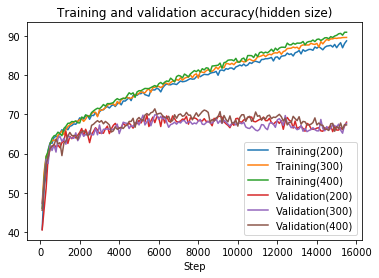

In [74]:
plt.figure()
plt.plot(step_numbers, train_accu_200_3_1, label='Training(200)')
plt.plot(step_numbers, train_accu_300_3_1, label='Training(300)')
plt.plot(step_numbers, train_accu_400_3_1, label='Training(400)')
plt.plot(step_numbers, val_accu_200_3_1, label='Validation(200)')
plt.plot(step_numbers, val_accu_300_3_1, label='Validation(300)')
plt.plot(step_numbers, val_accu_400_3_1, label='Validation(400)')

plt.legend()
plt.xlabel('Step')
plt.ylabel=('Accuracy')
plt.title('Training and validation accuracy(hidden size)')
plt.show()
plt.close()

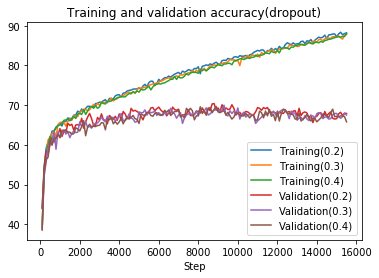

In [75]:
plt.figure()
plt.plot(step_numbers, train_accu_200_3_2, label='Training(0.2)')
plt.plot(step_numbers, train_accu_200_3_3, label='Training(0.3)')
plt.plot(step_numbers, train_accu_200_3_4, label='Training(0.4)')
plt.plot(step_numbers, val_accu_200_3_2, label='Validation(0.2)')
plt.plot(step_numbers, val_accu_200_3_3, label='Validation(0.3)')
plt.plot(step_numbers, val_accu_200_3_4, label='Validation(0.4)')

plt.legend()
plt.xlabel('Step')
plt.ylabel=('Accuracy')
plt.title('Training and validation accuracy(dropout)')
plt.show()
plt.close()

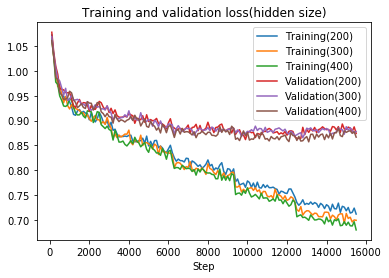

In [76]:
plt.figure()
plt.plot(step_numbers, train_loss_200_3_1, label='Training(200)')
plt.plot(step_numbers, train_loss_300_3_1, label='Training(300)')
plt.plot(step_numbers, train_loss_400_3_1, label='Training(400)')
plt.plot(step_numbers, val_loss_200_3_1, label='Validation(200)')
plt.plot(step_numbers, val_loss_300_3_1, label='Validation(300)')
plt.plot(step_numbers, val_loss_400_3_1, label='Validation(400)')

plt.legend()
plt.xlabel('Step')
plt.ylabel=('Loss')
plt.title('Training and validation loss(hidden size)')
plt.show()
plt.close()

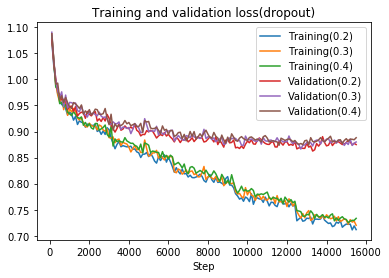

In [77]:
plt.figure()
plt.plot(step_numbers, train_loss_200_3_2, label='Training(0.2)')
plt.plot(step_numbers, train_loss_200_3_3, label='Training(0.3)')
plt.plot(step_numbers, train_loss_200_3_4, label='Training(0.4)')
plt.plot(step_numbers, val_loss_200_3_2, label='Validation(0.2)')
plt.plot(step_numbers, val_loss_200_3_3, label='Validation(0.3)')
plt.plot(step_numbers, val_loss_200_3_4, label='Validation(0.4)')

plt.legend()
plt.xlabel('Step')
plt.ylabel=('Loss')
plt.title('Training and validation loss(dropout)')
plt.show()
plt.close()

Model: RNN

In [27]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, dropout):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(pre_embedding_matrix))
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)

        return hidden.cuda()

    def forward(self, x1, x2, lengths1, lengths2):
        # reset hidden state

        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()

        self.hidden1 = self.init_hidden(batch_size1)
        self.hidden2 = self.init_hidden(batch_size2)

        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
        #embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, lengths1, batch_first=True)
        #embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, lengths2, batch_first=True)
        # fprop though RNN
        rnn_out1, self.hidden1 = self.rnn(embed1, self.hidden1)
        rnn_out2, self.hidden2 = self.rnn(embed2, self.hidden2)
        # undo packing
        #rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        #rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        # sum hidden activations of RNN across time
        rnn_out1 = torch.sum(rnn_out1, dim=1)
        rnn_out2 = torch.sum(rnn_out2, dim=1)
        
        rnn_out = torch.cat([rnn_out1, rnn_out2], 1)
        logits = self.fc1(rnn_out)
        logits = self.relu(logits)
        logits = self.dropout(logits)
        logits = self.fc2(logits)
        
        return logits

In [28]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    losses = 0
    model.eval()
    for data1, data2, lengths1, lengths2, labels in loader:
        data1_batch, data2_batch, lengths1_batch, lengths2_batch, label_batch = data1, data2, lengths1, lengths2, labels
        outputs = F.softmax(model(data1_batch.to(device=cuda).long(), data2_batch.to(device=cuda).long(), lengths1_batch.to(device=cuda), lengths2_batch.to(device=cuda)), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        total += labels.size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
        losses += loss.item()
    return (100 * correct / total), losses/len(loader)

In [29]:
model = RNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char), dropout=0.1).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_200_1 = []
val_accu_200_1 = []
train_loss_200_1 = []
val_loss_200_1 = []
step_numbers = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long(), lengths1.to(device=cuda), lengths2.to(device=cuda))
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            step_numbers.append(i + epoch * 3100)
            train_accu_200_1.append(train_acc)
            val_accu_200_1.append(val_acc)
            train_loss_200_1.append(train_los)
            val_loss_200_1.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))


Epoch: [1/5], Step: [101/3125], Train Accu: 33.654, Validation Accu: 33.1, Train Loss: 1.099198383102417, Val Loss: 1.0994747951626778
Epoch: [1/5], Step: [201/3125], Train Accu: 34.379, Validation Accu: 33.4, Train Loss: 1.0958659664916992, Val Loss: 1.0978038012981415
Epoch: [1/5], Step: [301/3125], Train Accu: 43.63, Validation Accu: 44.1, Train Loss: 1.0703719577980042, Val Loss: 1.0760911777615547
Epoch: [1/5], Step: [401/3125], Train Accu: 48.071, Validation Accu: 47.6, Train Loss: 1.0515569727134704, Val Loss: 1.0546782910823822
Epoch: [1/5], Step: [501/3125], Train Accu: 48.701, Validation Accu: 47.1, Train Loss: 1.0477193041610717, Val Loss: 1.0515375174582005
Epoch: [1/5], Step: [601/3125], Train Accu: 51.659, Validation Accu: 50.8, Train Loss: 1.0174540940856933, Val Loss: 1.0241439025849104
Epoch: [1/5], Step: [701/3125], Train Accu: 55.064, Validation Accu: 52.7, Train Loss: 1.0067887325668334, Val Loss: 1.014603141695261
Epoch: [1/5], Step: [801/3125], Train Accu: 59.016,

Epoch: [2/5], Step: [3101/3125], Train Accu: 71.793, Validation Accu: 67.0, Train Loss: 0.8752798307800292, Val Loss: 0.9066491965204477
Epoch: [3/5], Step: [101/3125], Train Accu: 72.268, Validation Accu: 67.3, Train Loss: 0.8652957931137085, Val Loss: 0.9049619492143393
Epoch: [3/5], Step: [201/3125], Train Accu: 72.595, Validation Accu: 65.3, Train Loss: 0.8681685463142395, Val Loss: 0.9146737772971392
Epoch: [3/5], Step: [301/3125], Train Accu: 72.884, Validation Accu: 67.0, Train Loss: 0.8614016107749939, Val Loss: 0.9066365454345942
Epoch: [3/5], Step: [401/3125], Train Accu: 73.029, Validation Accu: 68.3, Train Loss: 0.8645663804244995, Val Loss: 0.900436932221055
Epoch: [3/5], Step: [501/3125], Train Accu: 73.235, Validation Accu: 67.9, Train Loss: 0.8489313574409485, Val Loss: 0.893206249922514
Epoch: [3/5], Step: [601/3125], Train Accu: 73.289, Validation Accu: 68.0, Train Loss: 0.8600154156494141, Val Loss: 0.900746576488018
Epoch: [3/5], Step: [701/3125], Train Accu: 72.59,

Epoch: [4/5], Step: [3001/3125], Train Accu: 78.533, Validation Accu: 68.1, Train Loss: 0.8162838746833802, Val Loss: 0.8881291840225458
Epoch: [4/5], Step: [3101/3125], Train Accu: 78.63, Validation Accu: 68.4, Train Loss: 0.8249296154975891, Val Loss: 0.8904295936226845
Epoch: [5/5], Step: [101/3125], Train Accu: 79.096, Validation Accu: 68.5, Train Loss: 0.8035868835258484, Val Loss: 0.882158201187849
Epoch: [5/5], Step: [201/3125], Train Accu: 79.104, Validation Accu: 69.3, Train Loss: 0.7984738348960877, Val Loss: 0.8793078865855932
Epoch: [5/5], Step: [301/3125], Train Accu: 79.623, Validation Accu: 68.5, Train Loss: 0.7911915708160401, Val Loss: 0.8750256653875113
Epoch: [5/5], Step: [401/3125], Train Accu: 79.069, Validation Accu: 68.1, Train Loss: 0.8027507963180542, Val Loss: 0.8871404640376568
Epoch: [5/5], Step: [501/3125], Train Accu: 78.123, Validation Accu: 67.1, Train Loss: 0.8122281486701965, Val Loss: 0.8929457850754261
Epoch: [5/5], Step: [601/3125], Train Accu: 79.0

In [47]:
model = RNN(emb_size=300, hidden_size=300, num_layers=2, num_classes=3, vocab_size=len(id2char), dropout=0.1).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_300_1 = []
val_accu_300_1 = []
train_loss_300_1 = []
val_loss_300_1 = []
#step_numbers = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long(), lengths1.to(device=cuda), lengths2.to(device=cuda))
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            #step_numbers.append(i + epoch * 3100)
            train_accu_300_1.append(train_acc)
            val_accu_300_1.append(val_acc)
            train_loss_300_1.append(train_los)
            val_loss_300_1.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))


Epoch: [1/5], Step: [101/3125], Train Accu: 34.152, Validation Accu: 31.9, Train Loss: 1.0988984396743775, Val Loss: 1.1008787974715233
Epoch: [1/5], Step: [201/3125], Train Accu: 37.239, Validation Accu: 38.2, Train Loss: 1.090901958580017, Val Loss: 1.091123316437006
Epoch: [1/5], Step: [301/3125], Train Accu: 42.564, Validation Accu: 43.4, Train Loss: 1.0686910763168336, Val Loss: 1.0692712347954512
Epoch: [1/5], Step: [401/3125], Train Accu: 47.904, Validation Accu: 48.4, Train Loss: 1.0437659879875183, Val Loss: 1.0455689206719398
Epoch: [1/5], Step: [501/3125], Train Accu: 53.897, Validation Accu: 51.6, Train Loss: 1.0225822277069092, Val Loss: 1.0320889204740524
Epoch: [1/5], Step: [601/3125], Train Accu: 56.244, Validation Accu: 54.9, Train Loss: 0.9936738363456726, Val Loss: 0.9974746238440275
Epoch: [1/5], Step: [701/3125], Train Accu: 58.406, Validation Accu: 57.8, Train Loss: 0.9926268265151977, Val Loss: 0.9994228351861238
Epoch: [1/5], Step: [801/3125], Train Accu: 56.682

Epoch: [2/5], Step: [3101/3125], Train Accu: 72.84, Validation Accu: 67.3, Train Loss: 0.872793233127594, Val Loss: 0.9047919064760208
Epoch: [3/5], Step: [101/3125], Train Accu: 73.048, Validation Accu: 66.6, Train Loss: 0.8594414823913574, Val Loss: 0.9035924281924963
Epoch: [3/5], Step: [201/3125], Train Accu: 72.905, Validation Accu: 66.2, Train Loss: 0.864420302658081, Val Loss: 0.9008210133761168
Epoch: [3/5], Step: [301/3125], Train Accu: 73.501, Validation Accu: 67.2, Train Loss: 0.8446959684181213, Val Loss: 0.8925280049443245
Epoch: [3/5], Step: [401/3125], Train Accu: 73.312, Validation Accu: 65.8, Train Loss: 0.8591260504150391, Val Loss: 0.9047036357223988
Epoch: [3/5], Step: [501/3125], Train Accu: 72.514, Validation Accu: 67.1, Train Loss: 0.8672579840660095, Val Loss: 0.9057176243513823
Epoch: [3/5], Step: [601/3125], Train Accu: 73.448, Validation Accu: 67.6, Train Loss: 0.8609187050247192, Val Loss: 0.8988614957779646
Epoch: [3/5], Step: [701/3125], Train Accu: 73.803

Epoch: [4/5], Step: [3001/3125], Train Accu: 79.304, Validation Accu: 68.5, Train Loss: 0.8116379041481018, Val Loss: 0.8810502756386995
Epoch: [4/5], Step: [3101/3125], Train Accu: 79.154, Validation Accu: 69.0, Train Loss: 0.813940874710083, Val Loss: 0.882291754707694
Epoch: [5/5], Step: [101/3125], Train Accu: 79.395, Validation Accu: 69.1, Train Loss: 0.7921163324356079, Val Loss: 0.872856430709362
Epoch: [5/5], Step: [201/3125], Train Accu: 79.659, Validation Accu: 70.4, Train Loss: 0.7889527612495423, Val Loss: 0.8704344145953655
Epoch: [5/5], Step: [301/3125], Train Accu: 79.57, Validation Accu: 69.4, Train Loss: 0.7934052826499939, Val Loss: 0.8698956947773695
Epoch: [5/5], Step: [401/3125], Train Accu: 79.613, Validation Accu: 69.9, Train Loss: 0.7763534757804871, Val Loss: 0.8611718583852053
Epoch: [5/5], Step: [501/3125], Train Accu: 79.483, Validation Accu: 70.4, Train Loss: 0.7926618667793274, Val Loss: 0.8714328240603209
Epoch: [5/5], Step: [601/3125], Train Accu: 79.736

In [32]:
model = RNN(emb_size=300, hidden_size=400, num_layers=2, num_classes=3, vocab_size=len(id2char), dropout=0.1).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_400_1 = []
val_accu_400_1 = []
train_loss_400_1 = []
val_loss_400_1 = []
step_numbers = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long(), lengths1.to(device=cuda), lengths2.to(device=cuda))
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            step_numbers.append(i + epoch * 3100)
            train_accu_400_1.append(train_acc)
            val_accu_400_1.append(val_acc)
            train_loss_400_1.append(train_los)
            val_loss_400_1.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))


Epoch: [1/5], Step: [101/3125], Train Accu: 36.848, Validation Accu: 37.9, Train Loss: 1.0943957260894774, Val Loss: 1.096374984830618
Epoch: [1/5], Step: [201/3125], Train Accu: 40.22, Validation Accu: 40.2, Train Loss: 1.0854722037124633, Val Loss: 1.0857774280011654
Epoch: [1/5], Step: [301/3125], Train Accu: 47.613, Validation Accu: 45.6, Train Loss: 1.0561257844924927, Val Loss: 1.0597911663353443
Epoch: [1/5], Step: [401/3125], Train Accu: 47.719, Validation Accu: 47.4, Train Loss: 1.0461912141036986, Val Loss: 1.0468186065554619
Epoch: [1/5], Step: [501/3125], Train Accu: 54.775, Validation Accu: 56.8, Train Loss: 1.0125019227790832, Val Loss: 1.0116580296307802
Epoch: [1/5], Step: [601/3125], Train Accu: 54.182, Validation Accu: 55.3, Train Loss: 1.0116266666793823, Val Loss: 1.0144079942256212
Epoch: [1/5], Step: [701/3125], Train Accu: 58.319, Validation Accu: 58.3, Train Loss: 0.9973294890785217, Val Loss: 0.9993719402700663
Epoch: [1/5], Step: [801/3125], Train Accu: 59.462

Epoch: [2/5], Step: [3101/3125], Train Accu: 71.942, Validation Accu: 67.1, Train Loss: 0.865699828262329, Val Loss: 0.9055049084126949
Epoch: [3/5], Step: [101/3125], Train Accu: 72.647, Validation Accu: 68.7, Train Loss: 0.8539260105514527, Val Loss: 0.8871429059654474
Epoch: [3/5], Step: [201/3125], Train Accu: 72.579, Validation Accu: 67.5, Train Loss: 0.8591720066261291, Val Loss: 0.8863394483923912
Epoch: [3/5], Step: [301/3125], Train Accu: 73.304, Validation Accu: 68.2, Train Loss: 0.8642544178199768, Val Loss: 0.898452166467905
Epoch: [3/5], Step: [401/3125], Train Accu: 73.38, Validation Accu: 67.2, Train Loss: 0.8555732019042969, Val Loss: 0.9031426273286343
Epoch: [3/5], Step: [501/3125], Train Accu: 72.402, Validation Accu: 67.0, Train Loss: 0.8613611641693115, Val Loss: 0.9007836487144232
Epoch: [3/5], Step: [601/3125], Train Accu: 72.377, Validation Accu: 66.7, Train Loss: 0.8746479375839233, Val Loss: 0.9128874149173498
Epoch: [3/5], Step: [701/3125], Train Accu: 73.642

Epoch: [4/5], Step: [3001/3125], Train Accu: 78.976, Validation Accu: 69.7, Train Loss: 0.8080215669059754, Val Loss: 0.8767122905701399
Epoch: [4/5], Step: [3101/3125], Train Accu: 78.737, Validation Accu: 69.5, Train Loss: 0.8020868141746521, Val Loss: 0.870309192687273
Epoch: [5/5], Step: [101/3125], Train Accu: 79.421, Validation Accu: 70.7, Train Loss: 0.7911832584571838, Val Loss: 0.8600424695760012
Epoch: [5/5], Step: [201/3125], Train Accu: 79.763, Validation Accu: 70.0, Train Loss: 0.7998070737838745, Val Loss: 0.8697525914758444
Epoch: [5/5], Step: [301/3125], Train Accu: 79.519, Validation Accu: 71.1, Train Loss: 0.7890659004211426, Val Loss: 0.863264374434948
Epoch: [5/5], Step: [401/3125], Train Accu: 79.74, Validation Accu: 69.6, Train Loss: 0.7917519115638733, Val Loss: 0.8708857633173466
Epoch: [5/5], Step: [501/3125], Train Accu: 79.242, Validation Accu: 68.9, Train Loss: 0.7896044353866577, Val Loss: 0.867444971576333
Epoch: [5/5], Step: [601/3125], Train Accu: 79.862

In [33]:
model = RNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char), dropout=0.2).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_200_2 = []
val_accu_200_2 = []
train_loss_200_2 = []
val_loss_200_2 = []
#step_numbers = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long(), lengths1.to(device=cuda), lengths2.to(device=cuda))
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            #step_numbers.append(i + epoch * 3100)
            train_accu_200_2.append(train_acc)
            val_accu_200_2.append(val_acc)
            train_loss_200_2.append(train_los)
            val_loss_200_2.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))


Epoch: [1/5], Step: [101/3125], Train Accu: 34.272, Validation Accu: 36.3, Train Loss: 1.0983723556518554, Val Loss: 1.0995288118720055
Epoch: [1/5], Step: [201/3125], Train Accu: 37.402, Validation Accu: 35.5, Train Loss: 1.0933931924819946, Val Loss: 1.0939133875072002
Epoch: [1/5], Step: [301/3125], Train Accu: 38.297, Validation Accu: 36.5, Train Loss: 1.0872537828826905, Val Loss: 1.0918329618871212
Epoch: [1/5], Step: [401/3125], Train Accu: 43.673, Validation Accu: 43.3, Train Loss: 1.0682376542282104, Val Loss: 1.068612851202488
Epoch: [1/5], Step: [501/3125], Train Accu: 45.018, Validation Accu: 45.0, Train Loss: 1.0577693112182618, Val Loss: 1.0599495619535446
Epoch: [1/5], Step: [601/3125], Train Accu: 49.447, Validation Accu: 49.4, Train Loss: 1.0359578778266907, Val Loss: 1.040274215862155
Epoch: [1/5], Step: [701/3125], Train Accu: 51.721, Validation Accu: 49.9, Train Loss: 1.0311335131645203, Val Loss: 1.035204840824008
Epoch: [1/5], Step: [801/3125], Train Accu: 49.461,

Epoch: [2/5], Step: [3101/3125], Train Accu: 71.714, Validation Accu: 67.4, Train Loss: 0.8758289054679871, Val Loss: 0.9105524513870478
Epoch: [3/5], Step: [101/3125], Train Accu: 71.769, Validation Accu: 67.1, Train Loss: 0.8691030804252624, Val Loss: 0.9000394269824028
Epoch: [3/5], Step: [201/3125], Train Accu: 72.543, Validation Accu: 68.5, Train Loss: 0.8670100409698487, Val Loss: 0.9044004827737808
Epoch: [3/5], Step: [301/3125], Train Accu: 72.769, Validation Accu: 68.4, Train Loss: 0.8670220448684692, Val Loss: 0.9005643762648106
Epoch: [3/5], Step: [401/3125], Train Accu: 72.655, Validation Accu: 67.5, Train Loss: 0.8690371007728577, Val Loss: 0.9157307054847479
Epoch: [3/5], Step: [501/3125], Train Accu: 72.276, Validation Accu: 66.3, Train Loss: 0.8641363269233704, Val Loss: 0.909812718629837
Epoch: [3/5], Step: [601/3125], Train Accu: 72.704, Validation Accu: 67.5, Train Loss: 0.8615485500144958, Val Loss: 0.9031324218958616
Epoch: [3/5], Step: [701/3125], Train Accu: 72.7

Epoch: [4/5], Step: [3001/3125], Train Accu: 78.342, Validation Accu: 67.6, Train Loss: 0.8082800909614563, Val Loss: 0.8838343825191259
Epoch: [4/5], Step: [3101/3125], Train Accu: 78.135, Validation Accu: 66.7, Train Loss: 0.8216882000160217, Val Loss: 0.8928831703960896
Epoch: [5/5], Step: [101/3125], Train Accu: 78.405, Validation Accu: 68.0, Train Loss: 0.811667595653534, Val Loss: 0.8823170736432076
Epoch: [5/5], Step: [201/3125], Train Accu: 78.495, Validation Accu: 67.9, Train Loss: 0.80605882106781, Val Loss: 0.8810531385242939
Epoch: [5/5], Step: [301/3125], Train Accu: 78.581, Validation Accu: 68.8, Train Loss: 0.808961438999176, Val Loss: 0.8867903742939234
Epoch: [5/5], Step: [401/3125], Train Accu: 78.302, Validation Accu: 68.2, Train Loss: 0.8097035788536072, Val Loss: 0.8828093111515045
Epoch: [5/5], Step: [501/3125], Train Accu: 78.324, Validation Accu: 68.1, Train Loss: 0.8159313863945007, Val Loss: 0.8904381841421127
Epoch: [5/5], Step: [601/3125], Train Accu: 78.596

In [34]:
model = RNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char), dropout=0.3).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_200_3 = []
val_accu_200_3 = []
train_loss_200_3 = []
val_loss_200_3 = []
#step_numbers = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long(), lengths1.to(device=cuda), lengths2.to(device=cuda))
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            #step_numbers.append(i + epoch * 3100)
            train_accu_200_3.append(train_acc)
            val_accu_200_3.append(val_acc)
            train_loss_200_3.append(train_los)
            val_loss_200_3.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))


Epoch: [1/5], Step: [101/3125], Train Accu: 34.761, Validation Accu: 32.7, Train Loss: 1.0973108708190917, Val Loss: 1.0989848971366882
Epoch: [1/5], Step: [201/3125], Train Accu: 39.135, Validation Accu: 37.9, Train Loss: 1.0920217223739623, Val Loss: 1.0937887988984585
Epoch: [1/5], Step: [301/3125], Train Accu: 40.718, Validation Accu: 39.6, Train Loss: 1.0887214290618896, Val Loss: 1.0909622684121132
Epoch: [1/5], Step: [401/3125], Train Accu: 44.997, Validation Accu: 42.9, Train Loss: 1.0703601383018493, Val Loss: 1.071604896336794
Epoch: [1/5], Step: [501/3125], Train Accu: 44.239, Validation Accu: 45.2, Train Loss: 1.0613578548049927, Val Loss: 1.0608642417937517
Epoch: [1/5], Step: [601/3125], Train Accu: 50.007, Validation Accu: 48.1, Train Loss: 1.0385547259140016, Val Loss: 1.042934074997902
Epoch: [1/5], Step: [701/3125], Train Accu: 50.42, Validation Accu: 47.6, Train Loss: 1.0311615941810608, Val Loss: 1.0339629612863064
Epoch: [1/5], Step: [801/3125], Train Accu: 51.931,

Epoch: [2/5], Step: [3101/3125], Train Accu: 71.565, Validation Accu: 68.6, Train Loss: 0.8851620081329346, Val Loss: 0.9182775933295488
Epoch: [3/5], Step: [101/3125], Train Accu: 71.635, Validation Accu: 66.8, Train Loss: 0.8741901473426819, Val Loss: 0.9102392643690109
Epoch: [3/5], Step: [201/3125], Train Accu: 71.642, Validation Accu: 67.0, Train Loss: 0.8635051069450378, Val Loss: 0.9020861089229584
Epoch: [3/5], Step: [301/3125], Train Accu: 71.701, Validation Accu: 65.2, Train Loss: 0.8768468879508973, Val Loss: 0.9163893107324839
Epoch: [3/5], Step: [401/3125], Train Accu: 71.604, Validation Accu: 66.0, Train Loss: 0.8717292814064026, Val Loss: 0.9111670963466167
Epoch: [3/5], Step: [501/3125], Train Accu: 71.676, Validation Accu: 66.1, Train Loss: 0.8644896544647217, Val Loss: 0.9071590807288885
Epoch: [3/5], Step: [601/3125], Train Accu: 70.604, Validation Accu: 65.2, Train Loss: 0.8808158421325684, Val Loss: 0.9166990704834461
Epoch: [3/5], Step: [701/3125], Train Accu: 71.

Epoch: [4/5], Step: [3001/3125], Train Accu: 77.118, Validation Accu: 69.4, Train Loss: 0.8363874460983276, Val Loss: 0.9003686904907227
Epoch: [4/5], Step: [3101/3125], Train Accu: 77.745, Validation Accu: 68.6, Train Loss: 0.8216771928787231, Val Loss: 0.88823969848454
Epoch: [5/5], Step: [101/3125], Train Accu: 77.419, Validation Accu: 68.5, Train Loss: 0.8094020555496216, Val Loss: 0.8784299679100513
Epoch: [5/5], Step: [201/3125], Train Accu: 77.832, Validation Accu: 68.0, Train Loss: 0.8094274608612061, Val Loss: 0.8849975243210793
Epoch: [5/5], Step: [301/3125], Train Accu: 78.389, Validation Accu: 68.2, Train Loss: 0.8109845365524292, Val Loss: 0.8860075585544109
Epoch: [5/5], Step: [401/3125], Train Accu: 78.356, Validation Accu: 69.8, Train Loss: 0.8115790068817139, Val Loss: 0.8784319255501032
Epoch: [5/5], Step: [501/3125], Train Accu: 78.392, Validation Accu: 68.4, Train Loss: 0.8132755450630188, Val Loss: 0.8880115449428558
Epoch: [5/5], Step: [601/3125], Train Accu: 77.4

In [35]:
model = RNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=len(id2char), dropout=0.4).to(device=cuda)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_accu_200_4 = []
val_accu_200_4 = []
train_loss_200_4 = []
val_loss_200_4 = []
#step_numbers = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long(), lengths1.to(device=cuda), lengths2.to(device=cuda))
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc, train_los = test_model(train_loader, model)
            val_acc, val_los = test_model(val_loader, model)
            #step_numbers.append(i + epoch * 3100)
            train_accu_200_4.append(train_acc)
            val_accu_200_4.append(val_acc)
            train_loss_200_4.append(train_los)
            val_loss_200_4.append(val_los)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))


Epoch: [1/5], Step: [101/3125], Train Accu: 33.916, Validation Accu: 31.3, Train Loss: 1.1007541653060913, Val Loss: 1.1034783013164997
Epoch: [1/5], Step: [201/3125], Train Accu: 35.611, Validation Accu: 35.5, Train Loss: 1.0978489932632447, Val Loss: 1.0972503162920475
Epoch: [1/5], Step: [301/3125], Train Accu: 38.955, Validation Accu: 38.5, Train Loss: 1.0953703421401977, Val Loss: 1.0965214744210243
Epoch: [1/5], Step: [401/3125], Train Accu: 35.406, Validation Accu: 35.7, Train Loss: 1.0923144998550416, Val Loss: 1.092000737786293
Epoch: [1/5], Step: [501/3125], Train Accu: 44.142, Validation Accu: 42.0, Train Loss: 1.0827247021484374, Val Loss: 1.0829925201833248
Epoch: [1/5], Step: [601/3125], Train Accu: 46.948, Validation Accu: 45.0, Train Loss: 1.059885864944458, Val Loss: 1.0635757967829704
Epoch: [1/5], Step: [701/3125], Train Accu: 48.462, Validation Accu: 48.3, Train Loss: 1.0461958889961243, Val Loss: 1.047520276159048
Epoch: [1/5], Step: [801/3125], Train Accu: 49.22, 

Epoch: [2/5], Step: [3101/3125], Train Accu: 69.991, Validation Accu: 64.4, Train Loss: 0.9056124259376526, Val Loss: 0.9373011514544487
Epoch: [3/5], Step: [101/3125], Train Accu: 70.669, Validation Accu: 65.8, Train Loss: 0.8763912119483948, Val Loss: 0.9102705735713243
Epoch: [3/5], Step: [201/3125], Train Accu: 69.606, Validation Accu: 64.4, Train Loss: 0.8972446686553955, Val Loss: 0.9278300255537033
Epoch: [3/5], Step: [301/3125], Train Accu: 70.762, Validation Accu: 65.6, Train Loss: 0.9070216498184204, Val Loss: 0.9347119461745024
Epoch: [3/5], Step: [401/3125], Train Accu: 70.696, Validation Accu: 64.7, Train Loss: 0.8810816969680786, Val Loss: 0.9207617919892073
Epoch: [3/5], Step: [501/3125], Train Accu: 70.837, Validation Accu: 65.6, Train Loss: 0.875608489074707, Val Loss: 0.9148889724165201
Epoch: [3/5], Step: [601/3125], Train Accu: 71.213, Validation Accu: 66.8, Train Loss: 0.8747778954315185, Val Loss: 0.915151359513402
Epoch: [3/5], Step: [701/3125], Train Accu: 70.54

Epoch: [4/5], Step: [3001/3125], Train Accu: 76.206, Validation Accu: 67.7, Train Loss: 0.8301237790107727, Val Loss: 0.8879583403468132
Epoch: [4/5], Step: [3101/3125], Train Accu: 76.559, Validation Accu: 68.2, Train Loss: 0.8253777946853638, Val Loss: 0.888135576620698
Epoch: [5/5], Step: [101/3125], Train Accu: 76.923, Validation Accu: 68.3, Train Loss: 0.8222042098617554, Val Loss: 0.8894783016294241
Epoch: [5/5], Step: [201/3125], Train Accu: 76.952, Validation Accu: 67.9, Train Loss: 0.8149643972587586, Val Loss: 0.8838412743061781
Epoch: [5/5], Step: [301/3125], Train Accu: 77.209, Validation Accu: 67.7, Train Loss: 0.8183435167312622, Val Loss: 0.8867054339498281
Epoch: [5/5], Step: [401/3125], Train Accu: 76.925, Validation Accu: 68.6, Train Loss: 0.8229781829452515, Val Loss: 0.8903579860925674
Epoch: [5/5], Step: [501/3125], Train Accu: 76.564, Validation Accu: 68.4, Train Loss: 0.8185041744804382, Val Loss: 0.8832779657095671
Epoch: [5/5], Step: [601/3125], Train Accu: 76.

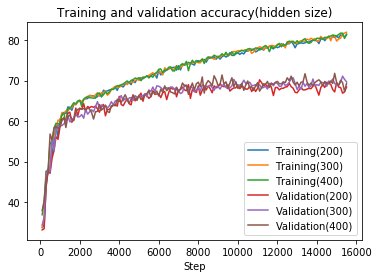

In [36]:
plt.figure()
plt.plot(step_numbers, train_accu_200_1, label='Training(200)')
plt.plot(step_numbers, train_accu_300_1, label='Training(300)')
plt.plot(step_numbers, train_accu_400_1, label='Training(400)')
plt.plot(step_numbers, val_accu_200_1, label='Validation(200)')
plt.plot(step_numbers, val_accu_300_1, label='Validation(300)')
plt.plot(step_numbers, val_accu_400_1, label='Validation(400)')

plt.legend()
plt.xlabel('Step')
plt.ylabel=('Accuracy')
plt.title('Training and validation accuracy(hidden size)')
plt.show()
plt.close()

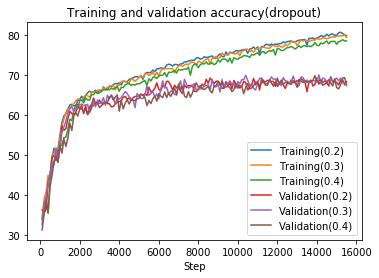

In [37]:
plt.figure()
plt.plot(step_numbers, train_accu_200_2, label='Training(0.2)')
plt.plot(step_numbers, train_accu_200_3, label='Training(0.3)')
plt.plot(step_numbers, train_accu_200_4, label='Training(0.4)')
plt.plot(step_numbers, val_accu_200_2, label='Validation(0.2)')
plt.plot(step_numbers, val_accu_200_3, label='Validation(0.3)')
plt.plot(step_numbers, val_accu_200_4, label='Validation(0.4)')

plt.legend()
plt.xlabel('Step')
plt.ylabel=('Accuracy')
plt.title('Training and validation accuracy(dropout)')
plt.show()
plt.close()

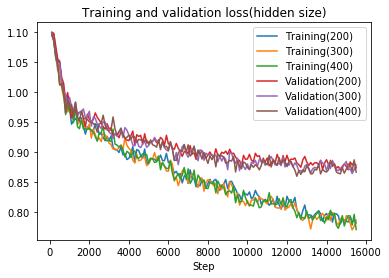

In [38]:
plt.figure()
plt.plot(step_numbers, train_loss_200_1, label='Training(200)')
plt.plot(step_numbers, train_loss_300_1, label='Training(300)')
plt.plot(step_numbers, train_loss_400_1, label='Training(400)')
plt.plot(step_numbers, val_loss_200_1, label='Validation(200)')
plt.plot(step_numbers, val_loss_300_1, label='Validation(300)')
plt.plot(step_numbers, val_loss_400_1, label='Validation(400)')

plt.legend()
plt.xlabel('Step')
plt.ylabel=('Loss')
plt.title('Training and validation loss(hidden size)')
plt.show()
plt.close()

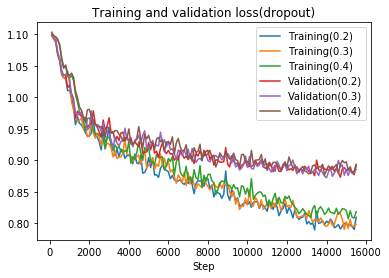

In [39]:
plt.figure()
plt.plot(step_numbers, train_loss_200_2, label='Training(0.2)')
plt.plot(step_numbers, train_loss_200_3, label='Training(0.3)')
plt.plot(step_numbers, train_loss_200_4, label='Training(0.4)')
plt.plot(step_numbers, val_loss_200_2, label='Validation(0.2)')
plt.plot(step_numbers, val_loss_200_3, label='Validation(0.3)')
plt.plot(step_numbers, val_loss_200_4, label='Validation(0.4)')

plt.legend()
plt.xlabel('Step')
plt.ylabel=('Loss')
plt.title('Training and validation loss(dropout)')
plt.show()
plt.close()

In [97]:
number = 3
s1 = ''
s2 = ''
for data1, data2, lengths1, lengths2, labels in val_loader:
    data1_batch, data2_batch, lengths1_batch, lengths2_batch, label_batch = data1, data2, lengths1, lengths2, labels
    outputs = F.softmax(model(data1_batch.to(device=cuda).long(), data2_batch.to(device=cuda).long(), lengths1_batch.to(device=cuda), lengths2_batch.to(device=cuda)), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    for i in range(len(outputs)):
        if predicted[i].eq(labels.to(device=cuda)[i].view_as(predicted[i])).sum().item() != 1:
            number = number - 1
            for j in data1_batch[i]:
                if j.item()!=0:
                    s1 = s1 + id2char[j.item()] + ' '
            for j in data2_batch[i]:
                if j.item()!=0:
                    s2 = s2 + id2char[j.item()] + ' '
            print(s1[:-1])
            print(s2[:-1])
            s1 = ''
            s2 = ''
            print('Real label:', labels[i].item())
            print('Predicted label:', predicted[i].item())
            print()
        if number == 0:
            break
    break

a man in a blue shirt and blue jeans rides a dark brown horse with white feet at the rodeo .
a man rides a bike
Real label: 0
Predicted label: 2

a girl in green looks at the camera and stands in front of a huge crowd of indescript faces .
a boy looks at a camera
Real label: 0
Predicted label: 2

two competitors in the last leg of a race , strong legs , long strides to the end .
the crowd is cheering them on .
Real label: 1
Predicted label: 2



In [98]:
number = 3
s1 = ''
s2 = ''
for data1, data2, lengths1, lengths2, labels in val_loader:
    data1_batch, data2_batch, lengths1_batch, lengths2_batch, label_batch = data1, data2, lengths1, lengths2, labels
    outputs = F.softmax(model(data1_batch.to(device=cuda).long(), data2_batch.to(device=cuda).long(), lengths1_batch.to(device=cuda), lengths2_batch.to(device=cuda)), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    for i in range(len(outputs)):
        if predicted[i].eq(labels.to(device=cuda)[i].view_as(predicted[i])).sum().item() == 1:
            number = number - 1
            for j in data1_batch[i]:
                if j.item()!=0:
                    s1 = s1 + id2char[j.item()] + ' '
            for j in data2_batch[i]:
                if j.item()!=0:
                    s2 = s2 + id2char[j.item()] + ' '
            print(s1[:-1])
            print(s2[:-1])
            s1 = ''
            s2 = ''
            print('Real label:', labels[i].item())
            print('Predicted label:', predicted[i].item())
            print()
        if number == 0:
            break
    break

a west virginia university women 's basketball team , officials , and a small gathering of fans are in a west virginia arena .
women are playing a big 12 conference game
Real label: 1
Predicted label: 1

person with a black helmet and vest , with a white undershirt , riding on a motorcycle on the street .
a man drives his car to the fair .
Real label: 0
Predicted label: 0

two orthodox jews , one male , one female , are shown in traditional dress in a sidewalk scene .
two jews celebrate the jewish holiday indoors .
Real label: 0
Predicted label: 0



Evaluating on MultiNLI

In [40]:
test_data = pd.read_csv('./hw2_data/mnli_val.tsv', sep='\t')

In [41]:
test_data.head()

,sentence1,sentence2,label,genre
0,"'Not entirely , ' I snapped , harsher than int...",I spoke more harshly than I wanted to .,entailment,fiction
1,cook and then the next time it would be my tur...,I would cook and then the next turn would be h...,contradiction,telephone
2,The disorder hardly seemed to exist before the...,The disorder did n't seem to be as common when...,entailment,slate
3,"The Report and Order , in large part , adopts ...",The Report and Order ignores recommendations f...,contradiction,government
4,"IDPA 's OIG 's mission is to prevent , detect ...",IDPA 's OIG 's mission is clear and cares abou...,entailment,government


In [42]:
test_data.genre.unique()

array(['fiction', 'telephone', 'slate', 'government', 'travel'],
      dtype=object)

In [43]:
test_data['label'] = test_data['label'].apply(label)
test_data['sentence1'] = test_data['sentence1'].apply(tokenize)
test_data['sentence2'] = test_data['sentence2'].apply(tokenize)

In [44]:
for genre in test_data.genre.unique():
    test_genre = test_data[test_data.genre==genre]
    test_genre = test_genre[['sentence1','sentence2','label']]
    
    test = []
    for data in test_genre.values:
        test.append(tuple(data))
        
    test_dataset = VocabDataset(test, char2id)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
    
    test_acc, test_los = test_model(test_loader, model)
    print('Model: {}, Genre: {}, Test Accu: {}, Test Loss: {}'.format('RNN', genre, test_acc, test_los)) # RNN

Model: RNN, Genre: fiction, Test Accu: 46.93467336683417, Test Loss: 1.0441669933497906
Model: RNN, Genre: telephone, Test Accu: 48.656716417910445, Test Loss: 1.0323259066790342
Model: RNN, Genre: slate, Test Accu: 43.11377245508982, Test Loss: 1.0603975262492895
Model: RNN, Genre: government, Test Accu: 48.523622047244096, Test Loss: 1.0305396802723408
Model: RNN, Genre: travel, Test Accu: 45.41751527494908, Test Loss: 1.041135336122205


In [48]:
torch.save(model.state_dict(), './best_model.pt') 

In [133]:
for genre in test_data.genre.unique():
    test_genre = test_data[test_data.genre==genre]
    test_genre = test_genre[['sentence1','sentence2','label']]
    
    test = []
    for data in test_genre.values:
        test.append(tuple(data))
        
    test_dataset = VocabDataset(test, char2id)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
    
    test_acc, test_los = test_model(test_loader, model)
    print('Model: {}, Genre: {}, Test Accu: {}, Test Loss: {}'.format('CNN', genre, test_acc, test_los)) # CNN

Model: CNN, Genre: fiction, Test Accu: 45.527638190954775, Test Loss: 1.0563324801623821
Model: CNN, Genre: telephone, Test Accu: 45.87064676616915, Test Loss: 1.0405623503029346
Model: CNN, Genre: slate, Test Accu: 45.00998003992016, Test Loss: 1.059514358639717
Model: CNN, Genre: government, Test Accu: 47.539370078740156, Test Loss: 1.0437993444502354
Model: CNN, Genre: travel, Test Accu: 45.723014256619145, Test Loss: 1.0462398452143515


Fine-tuning on MultiNLI

In [118]:
mnli_train_data = pd.read_csv('./hw2_data/mnli_train.tsv', sep='\t')
mnli_val_data = pd.read_csv('./hw2_data/mnli_val.tsv', sep='\t')

In [120]:
mnli_train_data['label'] = mnli_train_data['label'].apply(label)
mnli_train_data['sentence1'] = mnli_train_data['sentence1'].apply(tokenize)
mnli_train_data['sentence2'] = mnli_train_data['sentence2'].apply(tokenize)

mnli_val_data['label'] = mnli_val_data['label'].apply(label)
mnli_val_data['sentence1'] = mnli_val_data['sentence1'].apply(tokenize)
mnli_val_data['sentence2'] = mnli_val_data['sentence2'].apply(tokenize)

In [121]:
for genre in mnli_train_data.genre.unique():
    mnli_train_genre = mnli_train_data[mnli_train_data.genre==genre]
    mnli_train_genre = mnli_train_data[['sentence1','sentence2','label']]
    
    mnli_val_genre = mnli_val_data[mnli_val_data.genre==genre]
    mnli_val_genre = mnli_val_data[['sentence1','sentence2','label']]
    
    mnli_train = []
    for data in mnli_train_genre.values:
        mnli_train.append(tuple(data))
        
    mnli_val = []
    for data in mnli_val_genre.values:
        mnli_val.append(tuple(data)) 
        
        
    mnli_train_dataset = VocabDataset(mnli_train, char2id)
    train_loader = torch.utils.data.DataLoader(dataset=mnli_train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
    
    mnli_val_dataset = VocabDataset(mnli_val, char2id)
    val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
    
    learning_rate = 3e-4
    num_epochs = 3 # number epoch to train
    
    model.load_state_dict(torch.load('./best_model.pt'))
    model.eval()

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)

    train_accu = []
    val_accu = []
    train_loss = []
    val_loss = []
    step_numbers = []
    for epoch in range(num_epochs):
        for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1.to(device=cuda).long(), data2.to(device=cuda).long(), lengths1.to(device=cuda), lengths2.to(device=cuda))
            loss = criterion(outputs, labels.to(device=cuda))

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc, train_los = test_model(train_loader, model)
                val_acc, val_los = test_model(val_loader, model)
                step_numbers.append(i + epoch * 600)
                train_accu.append(train_acc)
                val_accu.append(val_acc)
                train_loss.append(train_los)
                val_loss.append(val_los)
                print('Genre: {}, Epoch: [{}/{}], Step: [{}/{}], Train Accu: {}, Validation Accu: {}, Train Loss: {}, Val Loss: {}'.format(
                           genre, epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc, train_los, val_los))

Genre: telephone, Epoch: [1/3], Step: [101/625], Train Accu: 51.575, Validation Accu: 50.06, Train Loss: 1.0291576772689819, Val Loss: 1.0356624251717974
Genre: telephone, Epoch: [1/3], Step: [201/625], Train Accu: 52.585, Validation Accu: 52.28, Train Loss: 1.0274080766677856, Val Loss: 1.0325471276690246
Genre: telephone, Epoch: [1/3], Step: [301/625], Train Accu: 54.46, Validation Accu: 53.06, Train Loss: 1.021137780380249, Val Loss: 1.0287618401703562
Genre: telephone, Epoch: [1/3], Step: [401/625], Train Accu: 54.65, Validation Accu: 51.42, Train Loss: 1.014440269088745, Val Loss: 1.027335396617841
Genre: telephone, Epoch: [1/3], Step: [501/625], Train Accu: 56.675, Validation Accu: 53.96, Train Loss: 1.0045263761520387, Val Loss: 1.0179925735589046
Genre: telephone, Epoch: [1/3], Step: [601/625], Train Accu: 56.65, Validation Accu: 53.44, Train Loss: 1.0078040464401246, Val Loss: 1.024139214852813
Genre: telephone, Epoch: [2/3], Step: [101/625], Train Accu: 58.42, Validation Accu

Genre: government, Epoch: [1/3], Step: [201/625], Train Accu: 52.255, Validation Accu: 52.12, Train Loss: 1.0298670858383179, Val Loss: 1.0356593561020626
Genre: government, Epoch: [1/3], Step: [301/625], Train Accu: 54.28, Validation Accu: 53.36, Train Loss: 1.0232002246856688, Val Loss: 1.030274156931859
Genre: government, Epoch: [1/3], Step: [401/625], Train Accu: 55.505, Validation Accu: 51.96, Train Loss: 1.0142651622772216, Val Loss: 1.0262808112581825
Genre: government, Epoch: [1/3], Step: [501/625], Train Accu: 56.55, Validation Accu: 54.16, Train Loss: 1.0089467758178712, Val Loss: 1.0224394042780445
Genre: government, Epoch: [1/3], Step: [601/625], Train Accu: 56.595, Validation Accu: 53.74, Train Loss: 1.0046747274398804, Val Loss: 1.0206877543668078
Genre: government, Epoch: [2/3], Step: [101/625], Train Accu: 58.225, Validation Accu: 53.56, Train Loss: 0.9875946377754211, Val Loss: 1.0146058365038246
Genre: government, Epoch: [2/3], Step: [201/625], Train Accu: 60.275, Val